In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import torch

In [2]:
words = open('names.txt', 'r').read().splitlines()

In [3]:
# minimum and maximum length of names in file
min([len(w) for w in words]), max([len(w) for w in words]), len(words)

(2, 15, 32033)

In [4]:
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

- As we plan to do next char prediction
- one word goes as input, the next should be output
- Every word must be starting & ending with a identifier
- We can do distinct identifiers for both or same
- [\S, e, m, m, a, \E] be the chars
- Also, [., e, m, m, a, .] ca be possible

### Let's look at how the input-output pairs would look like

In [5]:
for w in words[:3]:
    list_w = list('.' + w + '.')
    # print(''.join(list_w))
    for ch1, ch2 in zip(list_w[:-1], list_w[1:]):
        print(f'{ch1} -> {ch2}')
    break

. -> e
e -> m
m -> m
m -> a
a -> .


- So our generative model:
- starts with an initial input `'.'`, which shoul trigger name generation
- and shall continue generating unless another `'.'` char is generated

### Counting bi-grams in the data

In [6]:
count_dict = {}
for w in words:
    chars = list('.' + w + '.')
    for ch1, ch2 in zip(chars[:-1], chars[1:]):
        bigram = (ch1, ch2)
        count_dict[bigram] = count_dict.get(bigram, 0) + 1

In [7]:
# we can look at most or least occuring bigrams in the data: by sorting count_dict

# sorted(count_dict.items()) # sorts on the first items, i.e. keys (the bigram pairs)
sorted_counts = sorted(count_dict.items(), key=lambda kv: -kv[1])
sorted_counts[:5]

[(('n', '.'), 6763),
 (('a', '.'), 6640),
 (('a', 'n'), 5438),
 (('.', 'a'), 4410),
 (('e', '.'), 3983)]

- For predicting next char based on a char
- On basis of counts
- We can store bigram counts in a 2-d array
- `row` will denote input char
- `col` will be prob of predicted char
- In our case, size of array would be 27x27
- coz, vocab constitutes: 26 alphabets + ',' = 27

In [8]:
import torch

In [9]:
vocab = ['.'] + sorted(list(set(''.join(words))))
vocab_size = len(vocab)

# mapping from char to integer, to fill the matrix
stoi = {ch: i for i,ch in enumerate(vocab)}

# inverse map, to decode while generation
itos = {i: ch for ch,i in stoi.items()}

In [10]:
N = torch.zeros((vocab_size, vocab_size), dtype=torch.int)
N.shape

torch.Size([27, 27])

In [11]:
# lets fill the matrix now
N = torch.zeros((vocab_size, vocab_size), dtype=torch.int)

for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1, ix2 = stoi[ch1], stoi[ch2]
        N[ix1, ix2] += 1

In [12]:
import matplotlib.pyplot as plt

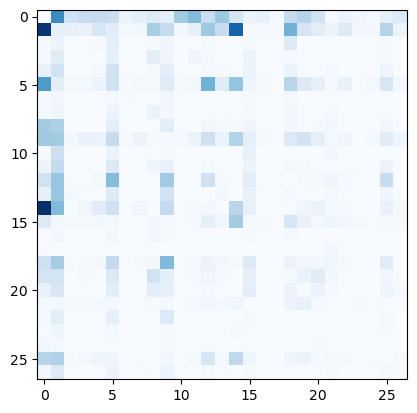

In [13]:
plt.imshow(N, cmap='Blues')

#### visualizing the count matrix

In [14]:
annot = np.empty_like(N, dtype=object)
for i in range(27):
    for j in range(27):
        annot[i,j] = f'{itos[i]}-{itos[j]}\n{N[i,j]}'

In [1]:
df = pd.DataFrame(N, index=stoi.keys(), columns=stoi.keys())

plt.figure(figsize=(18,16))
sns.heatmap(df, annot=annot, fmt="", cmap='Blues', cbar=True, square=True)

# plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

NameError: name 'pd' is not defined

- In above image, a count means: 'a-.' = 6640
- Shows, in out data, 6640 times a has been the last char

#### Now we should figure out how to sample and generate from this matrix

### Sampling
- to sample we need some kind of **probability distribution**
- we can convert these counts into prob distribution
- by converting to proportions along a `row`
- along a `row` - coz, at any instance we need to see what is the highest probability char to occur given current char

In [16]:
P = N / N.sum(dim=1, keepdim=True)

In [17]:
P[0]

tensor([0.0000, 0.1377, 0.0408, 0.0481, 0.0528, 0.0478, 0.0130, 0.0209, 0.0273,
        0.0184, 0.0756, 0.0925, 0.0491, 0.0792, 0.0358, 0.0123, 0.0161, 0.0029,
        0.0512, 0.0642, 0.0408, 0.0024, 0.0117, 0.0096, 0.0042, 0.0167, 0.0290])

- we can call this prob matrix as distribution learned by counting
- now let's see how can we sample from the learned prob. matrix

In [18]:
torch.multinomial(P[0], 1, replacement=True)

tensor([18])

- from prob distribution `P[0]`
- num of indices will be sampled in the probabilities given by that tensor
- If we sample enough times, we'll find that occurences are happening as per the probabilities

In [19]:
g = torch.Generator().manual_seed(2147483647)

for _ in range(10):
    ix = 0
    word = []
    while True:
        p = P[ix]
        ix = torch.multinomial(p, 1, replacement=True, generator=g).item()
        word.append(itos[ix])
        if ix == 0:
            break
    print(''.join(word))

cexze.
momasurailezitynn.
konimittain.
llayn.
ka.
da.
staiyaubrtthrigotai.
moliellavo.
ke.
teda.


#### Are we doing any better than randomly sampling out of a uniform distribution for every current char
- Means, prob distribution is uniform
- 1./27 for every row

In [20]:
g = torch.Generator().manual_seed(2147483647)

for _ in range(10):
    ix = 0
    word = []
    while True:
        # p = P[ix]
        p = torch.ones(27) / 27
        ix = torch.multinomial(p, 1, replacement=True, generator=g).item()
        word.append(itos[ix])
        if ix == 0:
            break
    print(''.join(word))

cexzm.
zoglkurkicqzktyhwmvmzimjttainrlkfukzkktda.
sfcxvpubjtbhrmgotzx.
iczixqctvujkwptedogkkjemkmmsidguenkbvgynywftbspmhwcivgbvtahlvsu.
dsdxxblnwglhpyiw.
igwnjwrpfdwipkwzkm.
desu.
firmt.
gbiksjbquabsvoth.
kuysxqevhcmrbxmcwyhrrjenvxmvpfkmwmghfvjzxobomysox.


### I think our count based sampling method, is somewhat better than the random baseline generations

----

## Evaluating performance - Summarize QUALITY of the model in SINGLE NUMBER
- maximising likelihood of the dataset
- maximizing product of all bigram probabilities -> also called **likelihood**
- maximizing sum of log of all bigram probabilities -> **log-likelihood**
- coz, all probs are b/w 0-1, logs are negative numbers, therefore, the sum of all is also negative
- Therefore, we MINIMIZE **negative log-likelihood**

## Maximizing likelihood == Minimizing negative log-likelihood

In [21]:
log_likelihood = 0
n = 0 # used to normalize the nll

for w in words:
    chs = ['.']+list(w)+['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1, ix2 = stoi[ch1], stoi[ch2]
        n += 1
        prob = P[ix1,ix2]
        logprob = torch.log(prob)
        # print(f'{ch1}{ch2}:: prob = {prob:.5f} | log-prob = {logprob:.5f}')
        log_likelihood += logprob

nll = - log_likelihood / n
print(f'log-likelihood = {log_likelihood}')
print(f'Negative log-likelihood = {nll:.5f}')

log-likelihood = -559891.75
Negative log-likelihood = 2.45409


In [22]:
# calculating likelihood of a word
n=0
log_likelihood = 0

chs = ['.'] + list('mrigankq') + ['.']
for ch1, ch2 in zip(chs, chs[1:]):
    ix1, ix2 = stoi[ch1], stoi[ch2]
    n += 1
    prob = P[ix1,ix2]
    logprob = torch.log(prob)
    # print(f'{ch1}{ch2}:: prob = {prob:.5f} | log-prob = {logprob:.5f}')
    log_likelihood += logprob
nll = -log_likelihood / n
print(f'{nll=}')

nll=tensor(inf)
